## Import and split data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter('ignore')
bikes=pd.read_csv('train.csv', index_col=0, parse_dates=True)

In [2]:
from sklearn.model_selection import train_test_split

def dfSplitter(df):
    #split data to training and testing data sets 
    y=df['count']
    X=df.iloc[:, :10]
    xTrain, xTest, yTrain, yTest=train_test_split(X, y, train_size=0.8, random_state=42)
    return(xTrain, xTest, yTrain, yTest)

In [3]:
xTrain, xTest, yTrain, yTest=dfSplitter(bikes)

## Cleanup data for Exploratory Data Analysis (EDA)

In [4]:
def cleanerX(X):
    X['month']=X.index.month
    X['day']=X.index.weekday
    X['hour']=X.index.hour
    X['dayName']=X.index.day_name()

## From EDA and feature selection, the ones that are worth a try for modeling: hour, workingday,  atemp, humidity, month,  holiday and season

## Feature Engineering I

#### Creating time peaks and interacting terms

In [5]:
cleanerX(xTrain)

In [6]:
def featEng(X):
    #creating month columns for peaks in june nad july 
    X['mJun']=np.abs(X['month']-6) 
    X['mJul']=np.abs(X['month']-7)
    #creating peak time columns
    X['8h']=np.abs(X['hour']-8)
    X['18h']=np.abs(X['hour']-18)
    #interaction terms 
    X['mJulHol']=X['mJul']*X['holiday']
    X['mJunWD']=X['mJun']*X['workingday']
    X['mJultemp']=X['mJul']*X['temp']
    X['mJulHum']=X['mJul']*X['humidity']
    return(X)

In [7]:
def featEng2(X,y):
    #remove problematic column
    X.drop(['dayName', 'casual', 'registered'], axis=1, inplace=True)
    #calculate log of count
    y=np.log(y+1)
    return(X,y)

In [8]:
xTrain=featEng(xTrain)

In [9]:
xTrain, yTrain=featEng2(xTrain, yTrain)

In [10]:
xTrain.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,day,hour,mJun,mJul,8h,18h,mJulHol,mJunWD,mJultemp,mJulHum
datetime,,,,,,,,,,,,,,,,,,,
2011-07-06 05:00:00,3,0,1,1,27.88,31.820,83,6.0032,7,2,5,1,0,3,13,0,1,0.0,0
2012-08-04 16:00:00,3,0,0,1,36.90,40.910,39,19.9995,8,5,16,2,1,8,2,0,0,36.9,39
2012-07-11 15:00:00,3,0,1,1,32.80,35.605,41,16.9979,7,2,15,1,0,7,3,0,1,0.0,0


In [11]:
yTrain.head()

datetime
2011-07-06 05:00:00    3.583519
2012-08-04 16:00:00    6.111467
2012-07-11 15:00:00    5.624018
2011-04-10 04:00:00    1.791759
2011-11-19 10:00:00    5.303305
Name: count, dtype: float64

## Modeling: no scaling, only log1p(y+1), exp(ypred) vs not

In [12]:
from sklearn.linear_model import LinearRegression
m=LinearRegression()
m.fit(xTrain, yTrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [13]:
m.score(xTrain, yTrain)

0.6271012242195796

In [14]:
xTrain['ypred']=m.predict(xTrain)

In [15]:
xTrain['ypred'].describe()

count    8708.000000
mean        4.593780
std         1.121003
min         1.073173
25%         3.834041
50%         4.811960
75%         5.485406
max         6.679346
Name: ypred, dtype: float64

In [16]:
(np.exp(xTrain['ypred'])-1).describe()

count    8708.000000
mean      159.513433
std       137.533529
min         1.924646
25%        45.249036
50%       121.972399
75%       240.146897
max       794.798731
Name: ypred, dtype: float64

In [17]:
xTrain['ypred2']=np.exp(xTrain['ypred'])-1

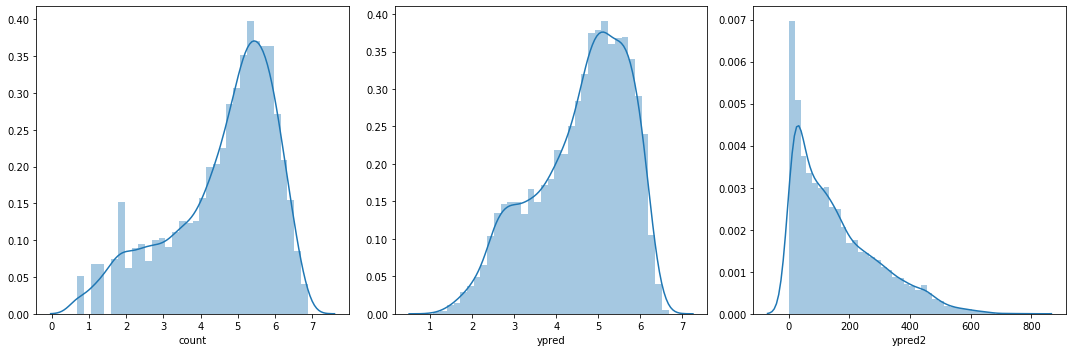

In [18]:
fig, g=plt.subplots(1,3, figsize=(15,5))
sns.distplot(yTrain, ax=g[0])
sns.distplot(xTrain['ypred'], ax=g[1])
sns.distplot(xTrain['ypred2'], ax=g[2])
plt.tight_layout()

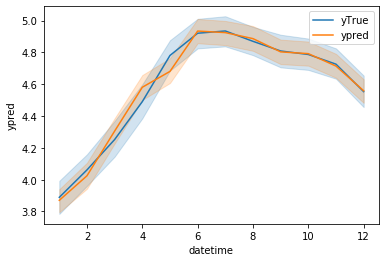

In [19]:
sns.lineplot(x=xTrain.index.month, y=yTrain, label='yTrue')
sns.lineplot(x=xTrain.index.month, y=xTrain['ypred'], label='ypred')

In [20]:
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(yTrain, xTrain['ypred']))

0.21066492406334797

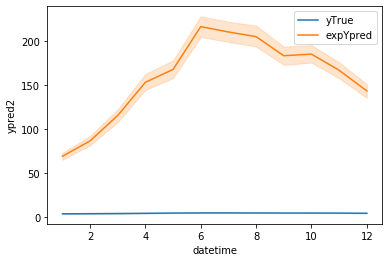

In [21]:
sns.lineplot(x=xTrain.index.month, y=yTrain, label='yTrue')
sns.lineplot(x=xTrain.index.month, y=xTrain['ypred2'], label='expYpred')

In [22]:
np.sqrt(mean_squared_log_error(yTrain, xTrain['ypred2']))

3.0527146044513294

## Modeling: with scalar, log1p(y+1), exp(ypred) vs not 

In [24]:
#prepare new training and testing sets for scaling 
xTrain, xTest, yTrain, yTest=dfSplitter(bikes)
cleanerX(xTrain)
xTrain, yTrain=featEng2(xTrain, yTrain)

In [27]:
from sklearn.preprocessing import StandardScaler

def dfScalar(X):
    #prepare a df for scaling 
    ts=X.index  
    col=X.columns
    #perform scaling transformation
    sc=StandardScaler()
    X=sc.fit_transform(X)
    #convert numpy array back to df
    X=pd.DataFrame(X, columns=col, index=ts)
    return(X)

In [28]:
#first scale all x and y features and then build interaction terms 
xTrain=dfScalar(xTrain)
xTrain=featEng(xTrain)

In [29]:
xTrain.head(3)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,month,day,hour,mJun,mJul,8h,18h,mJulHol,mJunWD,mJultemp,mJulHum
datetime,,,,,,,,,,,,,,,,,,,
2011-07-06 05:00:00,0.441439,-0.173335,0.684445,-0.657286,0.977262,0.960505,1.098553,-0.828356,0.138224,-0.509628,-0.945962,5.861776,6.861776,8.945962,18.945962,-1.189384,4.012065,6.705751,7.538026
2012-08-04 16:00:00,0.441439,-0.173335,-1.461037,-0.657286,2.135457,2.034991,-1.182694,0.878555,0.429385,0.990656,0.643217,5.570615,6.570615,7.356783,17.356783,-1.138916,-8.138874,14.031264,-7.771025
2012-07-11 15:00:00,0.441439,-0.173335,0.684445,-0.657286,1.609005,1.407912,-1.079001,0.512496,0.138224,-0.509628,0.498746,5.861776,6.861776,7.501254,17.501254,-1.189384,4.012065,11.040628,-7.403861


In [30]:
yTrain.head()

datetime
2011-07-06 05:00:00    3.583519
2012-08-04 16:00:00    6.111467
2012-07-11 15:00:00    5.624018
2011-04-10 04:00:00    1.791759
2011-11-19 10:00:00    5.303305
Name: count, dtype: float64

In [31]:
m=LinearRegression()
m.fit(xTrain, yTrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
m.score(xTrain, yTrain)

0.4656189789755296

In [33]:
xTrain['ypred']=m.predict(xTrain)

In [34]:
xTrain['ypred'].describe()

count    8708.000000
mean        4.679271
std         0.971413
min         2.281250
25%         3.843750
50%         4.718750
75%         5.531250
max         6.750000
Name: ypred, dtype: float64

In [35]:
(np.exp(xTrain['ypred'])-1).describe()

count    8708.000000
mean      163.538906
std       144.626449
min         8.788909
25%        45.700273
50%       111.028130
75%       251.459288
max       853.058763
Name: ypred, dtype: float64

In [36]:
xTrain['ypred2']=np.exp(xTrain['ypred'])-1

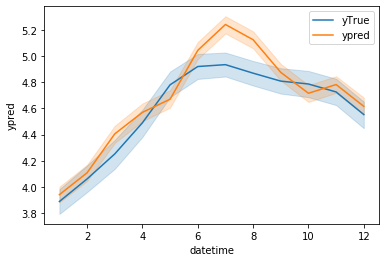

In [37]:
sns.lineplot(x=xTrain.index.month, y=yTrain, label='yTrue')
sns.lineplot(x=xTrain.index.month, y=xTrain['ypred'], label='ypred')

In [38]:
np.sqrt(mean_squared_log_error(yTrain, xTrain['ypred']))

0.23611630529037025

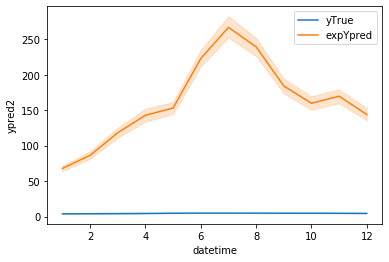

In [39]:
sns.lineplot(x=xTrain.index.month, y=yTrain, label='yTrue')
sns.lineplot(x=xTrain.index.month, y=xTrain['ypred2'], label='expYpred')

In [40]:
np.sqrt(mean_squared_log_error(yTrain, xTrain['ypred2']))

3.104457002842993

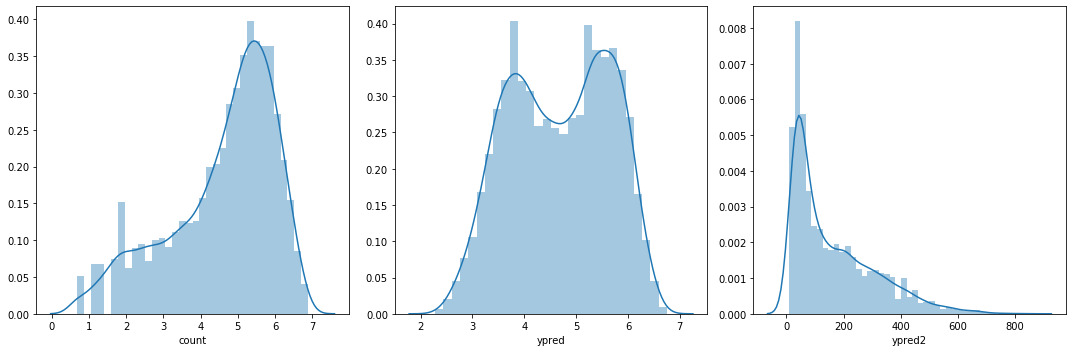

In [41]:
fig, g=plt.subplots(1,3, figsize=(15,5))
sns.distplot(yTrain, ax=g[0])
sns.distplot(xTrain['ypred'], ax=g[1])
sns.distplot(xTrain['ypred2'], ax=g[2])
plt.tight_layout()